## 项目需求

本次项目需要结合天气数据下的使用模式来预测共享自行车的租赁需求

## 分析过程

### 1. 数据变量说明

datetime：日期<br>
season:季节<br>
holiday:是否是节假日<br>
workdingday:是否是工作日<br>
weather: 1. 清澈，少云，多云;2. 雾+阴天，雾+碎云;3. 小雪、小雨+雷暴+散云，小雨+云;4. 暴雨+冰雹+雷暴+雾，雪+雾<br>
temp:温度<br>
atemp:体感温度<br>
humidity:相对湿度<br>
winspeed:风速<br>
casual:临时租赁数量<br>
registered:会员租赁数量<br>
count:总租赁数量<br>

### 2.数据准备

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from datetime import datetime

#读取数据
train = pd.read_csv('C:/Users/17372/Desktop/train.csv')
test = pd.read_csv('C:/Users/17372/Desktop/test.csv')

#### 2.1缺失值的处理

In [2]:
train.info()
print('='*50)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
datetime      6493 non-null object
season        6493 non-null int64
holiday       6493 non-null int64
workingday    6493 non-null int64
weather       6493 non-null int64
temp          6493 non-null float64
atemp         6493 non-null float64
humidity      6493 non-null int64
windspeed     64

#### 2.2异常值的处理

In [3]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


观察数据，可以看出总租赁数量(count)字段波动大，观察下其密度分布

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Distribution of count')

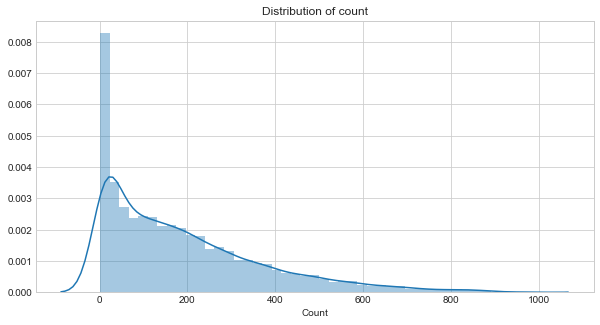

In [4]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)

sns.distplot(train['count'])
ax.set_xlabel('Count')
ax.set_title('Distribution of count')

数据密度分布倾斜的比较严重，先排除3个标准差以外的数据

In [5]:
train_withoutoutliers = train[np.abs(train['count']-train['count'].mean())<=(3*train['count'].std())]
#观察排除3个标准差后的统计描述
train_withoutoutliers['count'].describe()

count    10739.000000
mean       183.003818
std        166.681429
min          1.000000
25%         41.000000
50%        141.000000
75%        276.000000
max        734.000000
Name: count, dtype: float64

波动依然很大，选择对数变化对数据进行变换，使数据相对稳定

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


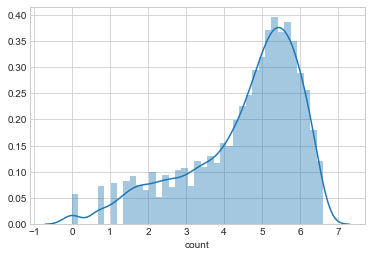

In [6]:
y_labels = train_withoutoutliers['count']
y_labels_log = np.log(y_labels)
sns.distplot(y_labels_log)

In [7]:
y_labels_log.describe()

count    10739.000000
mean         4.523107
std          1.477597
min          0.000000
25%          3.713572
50%          4.948760
75%          5.620401
max          6.598509
Name: count, dtype: float64

经过对数变换后，波动变小

In [8]:
#合并两组数据集
bike_data = pd.concat([train_withoutoutliers,test],ignore_index=True)
bike_data.head()

,atemp,casual,count,datetime,holiday,humidity,registered,season,temp,weather,windspeed,workingday
0,14.395,3.0,16.0,2011-01-01 00:00:00,0,81,13.0,1,9.84,1,0.0,0
1,13.635,8.0,40.0,2011-01-01 01:00:00,0,80,32.0,1,9.02,1,0.0,0
2,13.635,5.0,32.0,2011-01-01 02:00:00,0,80,27.0,1,9.02,1,0.0,0
3,14.395,3.0,13.0,2011-01-01 03:00:00,0,75,10.0,1,9.84,1,0.0,0
4,14.395,0.0,1.0,2011-01-01 04:00:00,0,75,1.0,1,9.84,1,0.0,0


接下来对datetime变量进行拆分，变成年，月，日期，时段，星期共五列

In [9]:
bike_data['year'] = bike_data.datetime.apply( lambda x : x.split( )[0].split('-')[0]).astype('int')
bike_data['month']=bike_data.datetime.apply( lambda x : x.split( )[0].split('-')[1]).astype('int')
bike_data['date']=bike_data.datetime.apply( lambda x : x.split( )[0])
bike_data['hour']=bike_data.datetime.apply( lambda x : x.split( )[1].split(':')[0]).astype('int')
bike_data['weekday']=bike_data.date.apply( lambda x : datetime.strptime(x,'%Y-%m-%d').isoweekday())
bike_data.head()

,atemp,casual,count,datetime,holiday,humidity,registered,season,temp,weather,windspeed,workingday,year,month,date,hour,weekday
0,14.395,3.0,16.0,2011-01-01 00:00:00,0,81,13.0,1,9.84,1,0.0,0,2011,1,2011-01-01,0,6
1,13.635,8.0,40.0,2011-01-01 01:00:00,0,80,32.0,1,9.02,1,0.0,0,2011,1,2011-01-01,1,6
2,13.635,5.0,32.0,2011-01-01 02:00:00,0,80,27.0,1,9.02,1,0.0,0,2011,1,2011-01-01,2,6
3,14.395,3.0,13.0,2011-01-01 03:00:00,0,75,10.0,1,9.84,1,0.0,0,2011,1,2011-01-01,3,6
4,14.395,0.0,1.0,2011-01-01 04:00:00,0,75,1.0,1,9.84,1,0.0,0,2011,1,2011-01-01,4,6


观察temp（温度），atemp（体感温度），humidity（湿度）、windspeed（风速）这四列也属于数值型数据，查看下其密度分布

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


[Text(0.5,0,'windspeed'), Text(0.5,1,'Distribution of windspeed')]

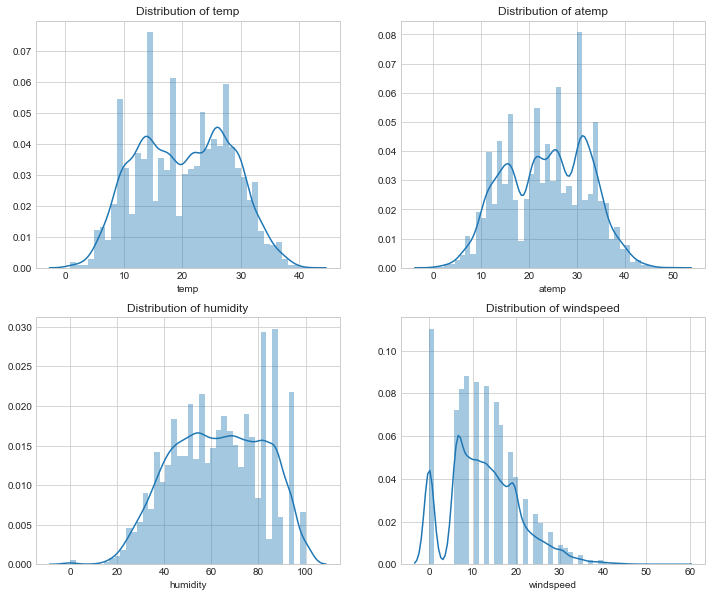

In [10]:
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(12,10)

sns.distplot(bike_data['temp'],ax=axes[0,0])
sns.distplot(bike_data['atemp'],ax=axes[0,1])
sns.distplot(bike_data['humidity'],ax=axes[1,0])
sns.distplot(bike_data['windspeed'],ax=axes[1,1])

axes[0,0].set(xlabel='temp',title='Distribution of temp',)
axes[0,1].set(xlabel='atemp',title='Distribution of atemp')
axes[1,0].set(xlabel='humidity',title='Distribution of humidity')
axes[1,1].set(xlabel='windspeed',title='Distribution of windspeed')

In [11]:
print(bike_data['windspeed'].describe())
print('='*50)
bike_data[bike_data['windspeed'] !=0]['windspeed'].describe()

count    17232.000000
mean        12.728719
std          8.201072
min          0.000000
25%          7.001500
50%         12.998000
75%         16.997900
max         56.996900
Name: windspeed, dtype: float64


count    15068.000000
mean        14.556762
std          7.092624
min          6.003200
25%          8.998100
50%         12.998000
75%         19.001200
max         56.996900
Name: windspeed, dtype: float64

我们可以发现风速1-7之间的值很少，而风速为0的数值却很多，可以假设数据本身还是有缺失值的，不过都用0来代替了<br>
使用随机森林根据相同的年份，月份，季节，温度，湿度等几个特征来填充一下风速的缺失值。

In [12]:
from sklearn.ensemble import RandomForestRegressor

bike_data['windspeed_rfr']=bike_data["windspeed"]
# 将数据分成风速等于0和不等于两部分
dataWind0 = bike_data[bike_data["windspeed_rfr"]==0]
dataWindNot0 = bike_data[bike_data["windspeed_rfr"]!=0]
#选定模型
rfModel_wind = RandomForestRegressor(n_estimators=1000,random_state=42)
# 选定特征值
windColumns = ["season","weather","humidity","month","temp","year","atemp"]
# 将风速不等于0的数据作为训练集，fit到RandomForestRegressor之中
rfModel_wind.fit(dataWindNot0[windColumns], dataWindNot0["windspeed_rfr"])
#通过训练好的模型预测风速
wind0Values = rfModel_wind.predict(X= dataWind0[windColumns])
#将预测的风速填充到风速为零的数据中
dataWind0.loc[:,"windspeed_rfr"] = wind0Values
#连接两部分数据
bike_data = dataWindNot0.append(dataWind0)
bike_data.reset_index(inplace=True)
bike_data.drop('index',inplace=True,axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Distribution of windspeed')

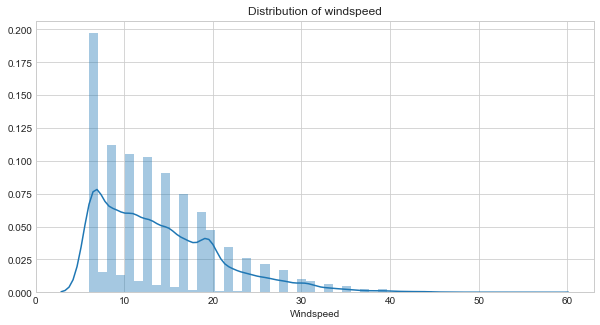

In [13]:
#观察处理后的风速变量的密度分布
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)

sns.distplot(bike_data['windspeed_rfr'])
ax.set_xlabel('Windspeed')
ax.set_title('Distribution of windspeed')

### 3.分析数据

#### 3.1 整体观察
查看会员，非会员，总租赁数量与其他变量的联系

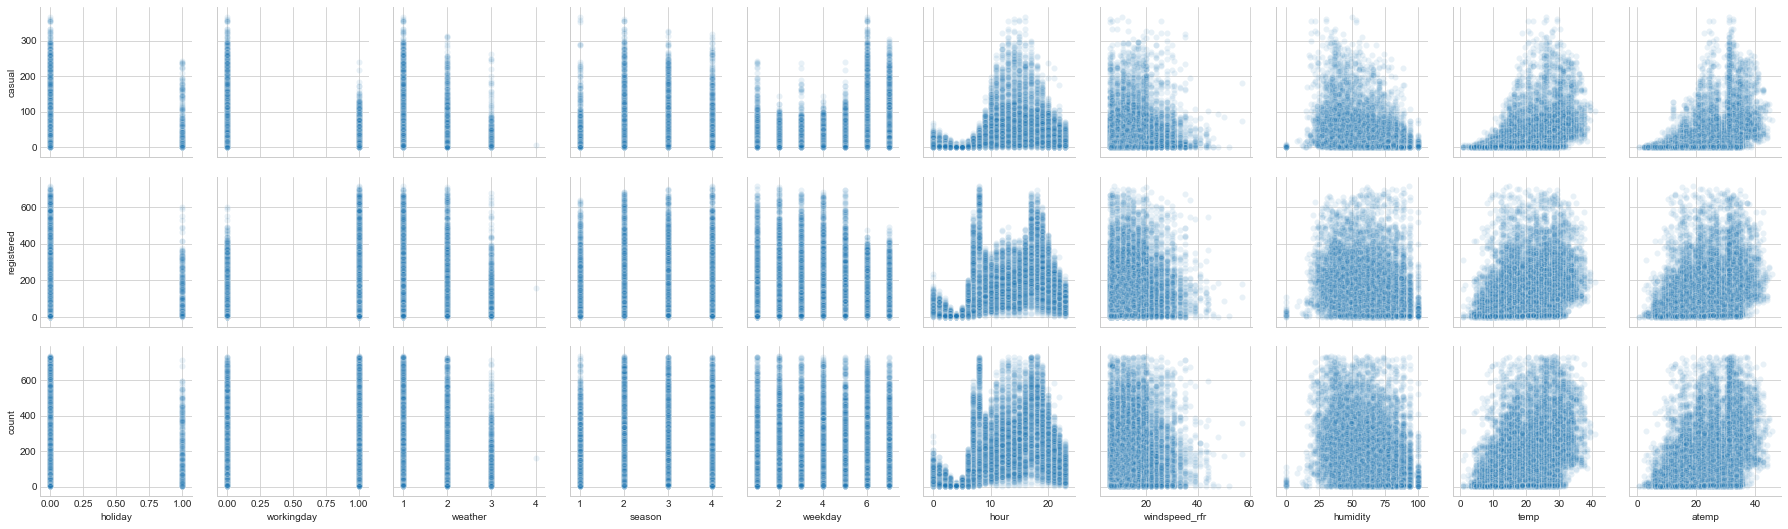

In [15]:
sns.pairplot(bike_data ,x_vars=['holiday','workingday','weather','season','weekday','hour','windspeed_rfr','humidity','temp','atemp'] ,
                        y_vars=['casual','registered','count'] , plot_kws={'alpha': 0.1})

从上表可以看出：<br>
1. 会员在工作日使用单车比非工作日多，而临时会员则恰好相反
2. 当天气逐渐变恶劣时，会员使用单车减少量的比例较非会员小
3. 第一季度的单车使用量最少
4. 会员使用单车会在两个时间点内使用最多，而非会员使用情况则成正态分布
5. 风力越大，使用单车的用户会越少
6. 湿度对非会员的影响非常大，对会员的影响则较小

In [21]:
# 查看各特征与count的相关性，
corrdf = bike_data.corr()
corrdf['count'].sort_values(ascending=False)

count            1.000000
registered       0.966209
casual           0.704764
hour             0.405437
temp             0.385954
atemp            0.381967
year             0.234959
month            0.164673
season           0.159801
windspeed_rfr    0.111783
windspeed        0.106074
weekday          0.022602
holiday          0.002978
workingday      -0.020764
weather         -0.127519
humidity        -0.317028
Name: count, dtype: float64

可以看出对总租赁数量影响力度的特征变量：时段>温度>湿度>年份>月份>季节>天气等级>风速>星期几>是否工作日>是否节假日

#### 3.2 时段对租赁数量的影响

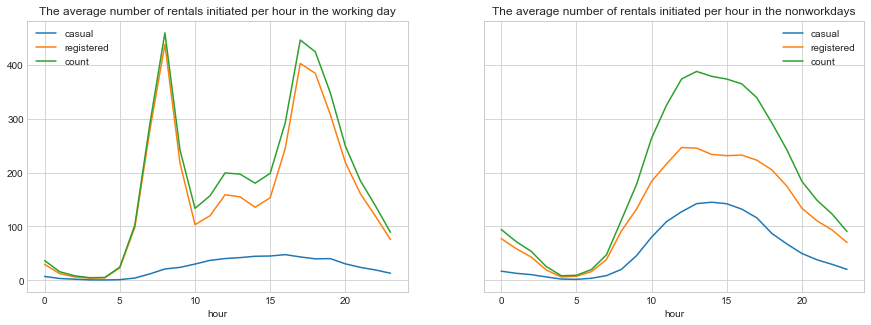

In [23]:
workingday_df = bike_data[bike_data['workingday']==1]
workingday_df = workingday_df.groupby('hour').agg({'casual':'mean','registered':'mean','count':'mean'})

non_workingday_df = bike_data[bike_data['workingday']==0]
non_workingday_df = non_workingday_df.groupby('hour').agg({'casual':'mean','registered':'mean','count':'mean'})

fig, axes = plt.subplots(1, 2,sharey = True)
workingday_df.plot(figsize=(15,5),title = 'The average number of rentals initiated per hour in the working day',ax=axes[0])
non_workingday_df.plot(figsize=(15,5),title = 'The average number of rentals initiated per hour in the nonworkdays',ax=axes[1])

对比上面两图可知：<br>
1. 工作日对于会员来说单车使用量有两个高峰，推测应该是上下班高峰期，中间有一个小高峰，推测是中午外出午餐的用户，而对于非会员来说则相对平缓。
2. 会员使用单车的数量大于非会员，尤其在工作日
3. 在非工作日，会员与非会员使用单车的数量呈现一个正态分布，高峰在13点左右，低谷在4点左右

#### 3.3 温度对租赁数量的影响

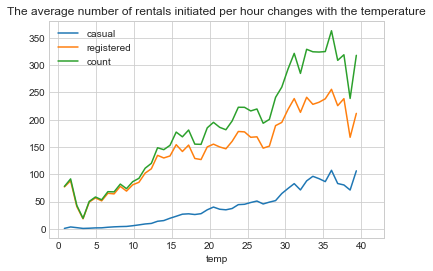

In [26]:
#按温度取租赁数量平均值
temp_rentals = bike_data.groupby('temp').agg({'casual':'mean', 'registered':'mean','count':'mean'})
temp_rentals .plot(title = 'The average number of rentals initiated per hour changes with the temperature')

观察可知，随着气温上升，租赁数量也随着增长，会员的增长速率大于非会员，而到36度左右租赁数量开始下降

#### 3.4湿度对租赁数量的影响

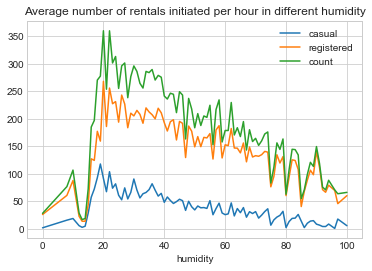

In [28]:
humidity_rentals = bike_data.groupby('humidity').agg({'casual':'mean','registered':'mean','count':'mean'})
humidity_rentals .plot (title = 'Average number of rentals initiated per hour in different humidity')

可以发现湿度到20租赁数量达到顶峰，随后开始下降

#### 3.5 年份月份对租赁数量的影响

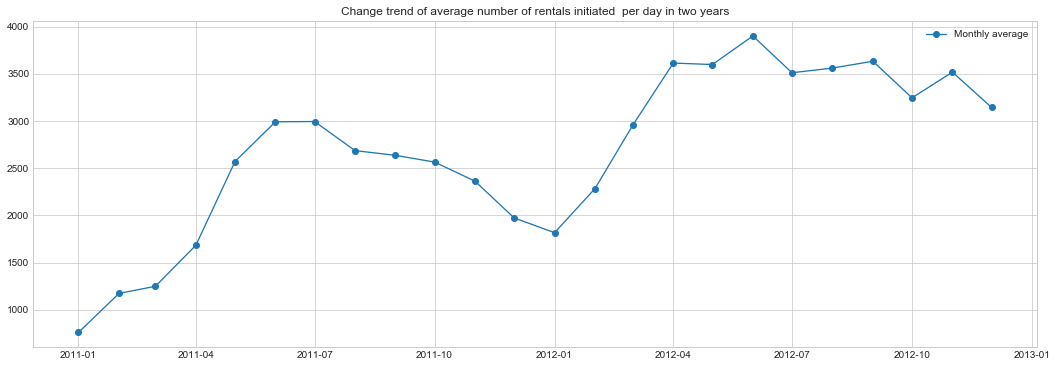

In [34]:
#先查看2年时间里租车数量随时间的变化
#数据按小时统计展示起来太麻烦，希望能够按天汇总
count_df = bike_data.groupby(['date','weekday'], as_index=False).agg({'year':'mean','month':'mean','casual':'sum','registered':'sum','count':'sum'})
#由于测试数据集中没有租赁信息，会导致折线图有断裂，所以将缺失的数据丢弃
count_df.dropna ( axis = 0 , how ='any', inplace = True )

#预计按天统计的波动仍然很大，再按月取日平均值
count_month = count_df.groupby(['year','month'], as_index=False).agg({'weekday':'min','casual':'mean', 'registered':'mean','count':'mean'})

#将按月统计数据设置一列时间序列
count_month.rename(columns={'weekday':'day'},inplace=True)
count_month['date']=pd.to_datetime(count_month[['year','month','day']])

#设置画框尺寸
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(1,1,1)

#使用折线图展示总体租赁情况（count）随时间的走势
ax.set_title('Change trend of average number of rentals initiated  per day in two years')
plt.plot(count_month['date'] , count_month['count'] , marker='o', 
linewidth=1.3 , label='Monthly average')
ax.legend()

观察上表可以看出:<br>
1. 2012租赁单车的数量明显比2011年有增长
2. 每年1月份单车使用数量最小

#### 3.6季节对租赁数量的影响

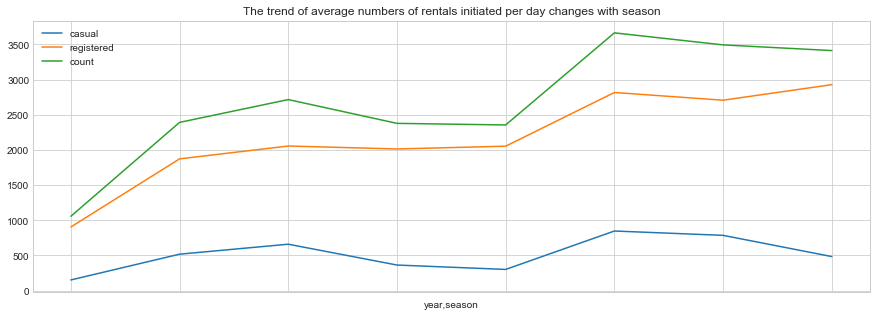

In [45]:
day_df=bike_data.groupby('date').agg({'year':'mean','season':'mean','casual':'sum', 'registered':'sum','count':'sum','temp':'mean','atemp':'mean'})
season_df = day_df.groupby(['year','season']).agg({'casual':'mean','registered':'mean','count':'mean'})

season_df.plot(figsize=(15,5),title='The trend of average numbers of rentals initiated per day changes with season')

可以看出春季单车使用数量最少，秋季达到最高峰

#### 3.7 天气状况对租赁数量的影响

In [47]:
count_weather = bike_data.groupby('weather')
count_weather[['casual','registered','count']].count()

,casual,registered,count
weather,,,
1,7076,7076,7076
2,2809,2809,2809
3,853,853,853
4,1,1,1


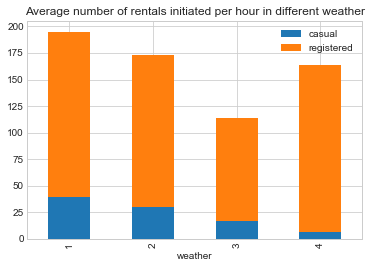

In [48]:
weather_df = bike_data.groupby('weather').agg({'casual':'mean','registered':'mean'})
weather_df.plot.bar(stacked=True,title = 'Average number of rentals initiated per hour in different weather')

可以看出，3号天气状况下单车使用量最小

#### 3.8风速对租赁数量的影响

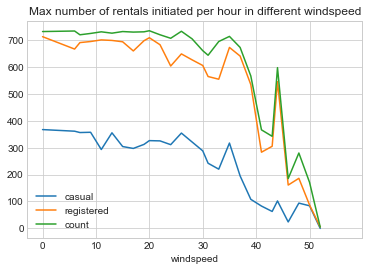

In [49]:
windspeed_rentals = bike_data.groupby('windspeed').agg({'casual':'max','registered':'max','count':'max'})
windspeed_rentals .plot(title = 'Max number of rentals initiated per hour in different windspeed')

可以看出，风速越大，租赁单车的数量则越小，但是在风速为40的时候有一次反弹，观察下异常数据

In [50]:
df2=bike_data[bike_data['windspeed']>40]
df2=df2[df2['count']>400]
df2

,atemp,casual,count,datetime,holiday,humidity,registered,season,temp,weather,windspeed,workingday,year,month,date,hour,weekday,windspeed_rfr
5721,31.06,52.0,597.0,2012-03-08 17:00:00,0,38,545.0,1,25.42,1,43.9989,1,2012,3,2012-03-08,17,4,43.9989


是一个下班高峰期的异常值

### 4.特征值的选取

根据之前的分析，我们将时段（hour）、温度（temp）、湿度（humidity）、年份（year）、月份（month）、季节（season）、天气等级（weather）、风速（windspeed_rfr）、星期几（weekday）、是否工作日（workingday）、是否假日（holiday），11项作为特征值

In [51]:
#对特征值进行one-hot编码
dummies_month = pd.get_dummies(bike_data['month'], prefix= 'month')
dummies_season=pd.get_dummies(bike_data['season'],prefix='season')
dummies_weather=pd.get_dummies(bike_data['weather'],prefix='weather')
dummies_year=pd.get_dummies(bike_data['year'],prefix='year')
#把5个新的DF和原来的表连接起来
bike_data=pd.concat([bike_data,dummies_month,dummies_season,dummies_weather,dummies_year],axis=1)

In [58]:
#分离训练集和测试集
train = bike_data[pd.notnull(bike_data['count'])]
test= bike_data[pd.isnull(bike_data['count'])].sort_values(by=['datetime'])
datetimecol = test['datetime']
yLabels=train['count']
yLabels_log=np.log(yLabels)

In [59]:
#丢弃不需要的字段
dropFeatures = ['casual' , 'count' , 'datetime' , 'date' , 'registered' ,'windspeed' , 'atemp' , 'month','season','weather', 'year' ]

train = train.drop(dropFeatures , axis=1)
test = test.drop(dropFeatures , axis=1)

### 5.选择模型，测试模型，训练模型

In [60]:
from sklearn.cross_validation import train_test_split
X = train
y = yLabels_log
#使用交叉验证检测模型
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

#使用随机森林模型
rfModel = RandomForestRegressor(n_estimators=1000 , random_state = 42)
rfModel.fit(X_train, y_train)
rfModel.score(X_test,y_test)

0.9065242139822439

In [61]:
#使用线性回归模型
from sklearn.linear_model import LinearRegression
li = LinearRegression()
li.fit(X_train,y_train)
print(li.score(X_test,y_test))

0.4459966765331125


In [62]:
#使用K近邻模型
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=6)
knn.fit(X_train,y_train)
print(knn.score(X_test,y_test))

0.7619399336397235


分析对比三个模型，选取正确率最高的模型来进行最终数据的预测，即随机森林模型

### 6.预测测试集数据

In [56]:
predsTest= rfModel.predict(X = test)
predsTest

array([3.24438146, 2.1243751 , 2.00805652, ..., 4.6061852 , 4.49708488,
       3.82743767])